# Clase 7

En esta clase vamos a tener la primera aproximación a redes neuronales utilizando Keras. En particular, vamos a tomar como guía el problema bien conocido de clasificación de dígitos escritos manualmente.

Para comenzar, vamos a importar los modulos necesarios.

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


A continuación cargamos el dataset. A diferencia de otros dataset que hemos usado, este ya viene divido en train y test, con 60.000 ejemplos de entrenamiento, y 10.000 en test.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Veamos algunos ejemplos del conjunto de entrenaiento...

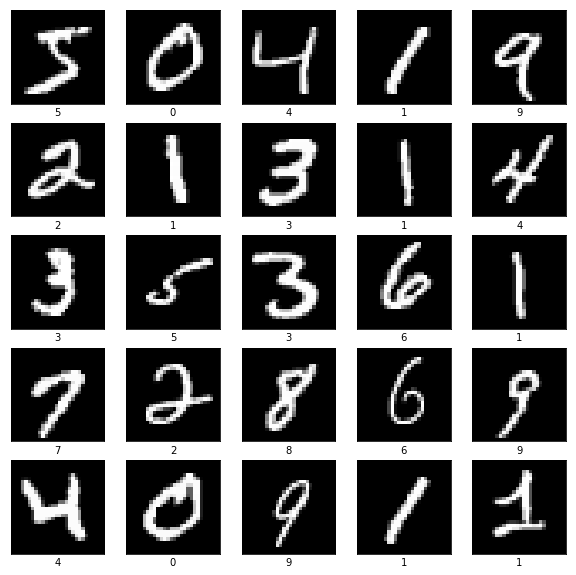

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(y_train[i])
plt.show()

El dataset esta compuesto por imágenes de 28 x 28 pixeles en escala de grises, que sencillamente se representa como una matriz de enteros, de 28 x 28, cuyos valores ven del 0 (negro absoluto) al 255 (completamente blanco).

De esta forma, x_train es de `(n_samples, height, width)`.

In [5]:
print('x_train es de ', x_train.shape)
print('x_test es de ', x_test.shape)
print('El tipo de datos es ', x_train.dtype)

x_train es de  (60000, 28, 28)
x_test es de  (10000, 28, 28)
El tipo de datos es  uint8


Si inspeccionamos el primer ejemplo de entrenamiento, vemos que el valor de los pixeles efectivamente van de 0 a 255, y que es de 28 x 28

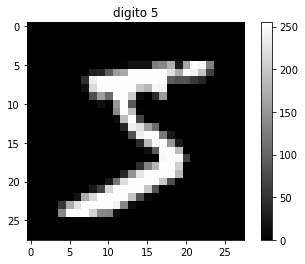

In [6]:
plt.title("digito {}".format(y_train[0]))
plt.imshow(x_train[0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocesamiento de los datos
En la siguiente celda, vamos a preprocesar las imagenes que vamos a utilizar antes de comenzar el entrenamiento:

Se pide:
 - Utilizando la operacion `reshape`, convertir los ejemplos de entrenamiento de matriz a vector
 - Convertir el tipo de los datos de tipo `np.uint8` a `np.float32`
 - Dividimos el valor de cada pixel entre 255 para asegurar que todos los pixeles queden en el rango $[0,1]$
 - Restamos a cada pixel 0.5 para asegurar que todos los pixeles queden en el rango $[-0.5,0.5]$


In [7]:
# Utilizando la operacion reshape, convertir las imagenes de matriz a vector
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
# Convertir el tipo de los datos de tipo np.uint8 a np.float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# Dividimos el valor de cada pixel entre 255. para asegurarnos que todos los pixeles queden en el rango $[0,1]$
x_train /= 255
x_test /= 255
# Restamos a cada pixel 0.5 para asegurarnos que todos los pixeles queden en el rango $[-0.5,0.5]$
x_train -= 0.5
x_test -= 0.5

print(x_train.shape)

(60000, 784)


In [8]:
# Verificamos que los pasos anteriores fueron correctos
assert x_train.ndim == 2, "Deben haber 2 dimenciones, hay {}".format(x_train.ndim)
assert x_train.min() == -.5, "El miimo debe ser -.5 pero es {}".format(x_train.min())
assert x_train.max() == .5, "El miimo debe ser .5 pero es {}".format(x_train.max())

Utilizando el metodo `train_test_split` tomar el 90% del conjunto de entrenamiento para entrenar, y utilizar el restante para validar, que llamaremos `x_val`, `y_val`, y que vamos a usar para tunear parametros

In [9]:
from sklearn.model_selection import train_test_split

print(x_train.shape)
print(y_train.shape)

# realizar la particion en entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Verificamos que todo este bien
assert len(x_train) == len(y_train)
assert len(x_val) == len(y_val)

(60000, 784)
(60000,)


## Keras Sequential Models API
Keras provee dos grandes APIs para trabajar con modelos: secuencial y funcional. En esta clase vamos a trabajar con la primera de ellas: _Keras Sequential Models_. Esta API permite crear modelos de deep leaning a partir de una instancia de la clase `Sequential` a la que luego se le crean y agregan las capas necesarias.

Por ejemplo, las capas pueden ser definidas y pasadas a la clase Sequential como una lista:

```python
from keras.models import Sequential
from keras.layers import Dense
model = Sequential([Dense(2, activation="relu", input_dim=1, name="hidden_layer"),
                    Dense(1, activation="sigmoid", name="output_layer")], name="my_model")
```

O pueden ser agregadas de a una:

```python
from keras.models import Sequential
from keras.layers import Dense
model = Sequential(name="my_model")
model.add(Dense(2, activation="relu",  input_dim=1, name="hidden_layer"))
model.add(Dense(1, activation="sigmoid", name="output_layer"))
```

En ambos casos, `model` es una red neuronal con dos capas, donde la primera tiene dos neuronas (capa oculta), y la segunda (capa de salida) tiene solo una.
`Dense` es simplemente una capa densa, también conocida como completamente conectada (fully conected).

En ambos casos, para cada capa, se indica la función de activación a utilizar. Los nombres, tanto de las capas como del modelo, son strings arbitrarios (es decir, texto) que facilitan la comprensión del modelo.

Esta clase permite desarrollar modelos para la mayoría de las aplicaciónes que vamos a ver, es muy sencilla aunque tiene sus limitaciones. por ejemplo, unicamente permite crear modelos de tipo _feed forward_.

Una vez creado el modelo, se puede ver un resumen de este con el método `summary`:
```python
model.summary()

```
Que muestra lo siguiente:
```
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
hidden_layer (Dense)         (None, 2)                 4         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 3         
=================================================================
Total params: 7
Trainable params: 7
Non-trainable params: 0
```

### Construir el modelo

**Se pide:** definir un modelo completamente conectado, que en su capa oculta tenga 32 neuronas, y su capa de salida 10 (una para cada digito). La capa de salida debe utilizar como activación la función softmax. Mostrar el resumen para el modelo dado.

In [10]:
from keras.models import Sequential
from keras.layers import Dense

# completar
model = Sequential(name='model_1')
model.add(Dense(32, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax', name='output_layer'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
output_layer (Dense)         (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### Compilar el modelo
Luego que el modelo es definido, antes de pasar al entrenamiento, se necesita configurar algunas cosas más, que se agregan durante el paso de compilación:
 - *loss function*: función de error a minimizar. Usualmente nos referimos a ella como _loss_ o _pérdida_
 - *optimizer*: algoritmo utilizado para optimizar la función. Escencialmente, a cuál algoritmo de descenso por gradiente utilizar. Debe ser un objeto del módulo [optimizers](https://keras.io/optimizers), instanciado con los parámetros deseados, o un string indicando cuál utilizar, en cuyo caso se utilizan los valores por defecto.
 - *metrics*: métricas a ser usadas para monitorear la evolución del entrenamiento. En este ejemplo, se utiliza el acierto (accuracy)
 
```python
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.000001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
```
**Se pide:** Compilar el modelo con la función [compile](https://keras.io/models/sequential/#compile), utilizando como optimizador una instancia de SGD, que tenga *learning rate* (`lr=0.01`), y los demás parámetros como en el ejemplo dado.

In [11]:
from keras.optimizers import SGD

# completar
model.compile(optimizer=SGD(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Entrenar el modelo
Este paso es en el que efectivamente se entrena la red. Se deben indicar algunos parámetros más, como los ejemplos de entrenamiento y validación, la cantidad de épocas y el tamaño del batch. Todo esto se hace con la función [fit](https://keras.io/models/sequential/#fit).

In [28]:
# completar
model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(x_val, y_val))

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 9s 171us/step - loss: 0.7205 - acc: 0.8078 - val_loss: 0.4187 - val_acc: 0.8833
Epoch 2/5
54000/54000 [==============================] - 9s 162us/step - loss: 0.3771 - acc: 0.8931 - val_loss: 0.3480 - val_acc: 0.9008
Epoch 3/5
54000/54000 [==============================] - 9s 162us/step - loss: 0.3344 - acc: 0.9035 - val_loss: 0.3193 - val_acc: 0.9102
Epoch 4/5
54000/54000 [==============================] - 9s 165us/step - loss: 0.3118 - acc: 0.9102 - val_loss: 0.3014 - val_acc: 0.9140
Epoch 5/5
54000/54000 [==============================] - 9s 165us/step - loss: 0.2959 - acc: 0.9143 - val_loss: 0.2862 - val_acc: 0.9148


Durante el entrenamiento, se muestra el progreso en salida estándar. Una vez terminado, es importante visualizar cómo evolucionó el modelo durante el entrenamiento. El comportamiento de las distintas métricas durante el entrenamiento arrojan pistas sobre qué está pasando.

En model.history queda el registro histórico de qué sucedió con la `accuracy` y `loss` durante el entrenamiento para ambos conjuntos.

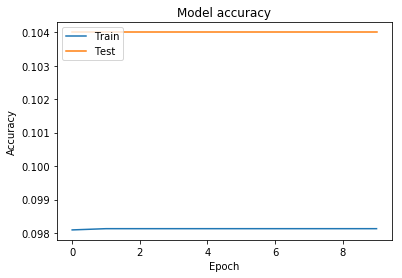

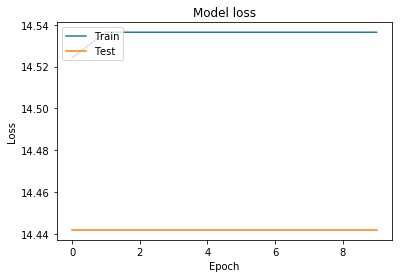

In [13]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.clf()

# Invocamos a la función plot?history para ver cómo se comportó
plot_history(model.history)

### Predecir
Una vez que tenemos el modelo entrenado, es interesante hacer predicciones con el, sobre distintas instancias. Para esto se cuenta con el método `predict`. Este método nos devuelve una matriz de dimenciones (n_samples, n_classes), donde cada fila contiene el valor de la función softmax para cada instancia clasificada.

In [30]:
predictions = model.predict(x_val)
predictions.shape

(6000, 10)

El siguiente vector contiene la predicción para el primer ejemplo de evaluación. El valor de cada entrada se puede interpretar como una probabilidad, y cada entrada de este vector contiene la probabilidad de que el ejemplo pertenezca a la respectiva clase.

In [31]:
predictions[0]

array([  4.50991502e-06,   1.53827023e-06,   9.32448998e-08,
         1.29387691e-03,   2.50701542e-05,   1.82606731e-04,
         2.05666211e-07,   9.96325076e-01,   9.00557934e-05,
         2.07688683e-03], dtype=float32)

Utilizando la función de numpy np.argmax podemos obtener, para cada instancia, cuál es la clase que tiene mayor probabilidad, y utilizar esta clase como nuestra predicción

In [32]:
y_val_pred = np.argmax(predictions, axis=1)

Una vez que tenemos las predicciones hechas por la red, y sus valores reales, se puede utilizar cualquier métrica del módulo [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) que hemos usado antes:

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

             precision    recall  f1-score   support

          0       0.95      0.96      0.95       624
          1       0.94      0.96      0.95       654
          2       0.91      0.89      0.90       572
          3       0.89      0.89      0.89       589
          4       0.92      0.91      0.92       580
          5       0.91      0.85      0.88       551
          6       0.91      0.97      0.94       580
          7       0.94      0.91      0.93       633
          8       0.87      0.88      0.87       585
          9       0.91      0.91      0.91       632

avg / total       0.91      0.91      0.91      6000



En este punto se espera que tengan un manejo mínimo de keras como para entrenar un modelo. En los próximos pasos, el objetivo es entender qué efecto tiene cada parámetro.

**learning rate**:Implementar un modelo exactamente igual al anterior. Entrenarlo durante 10 épocas, con `lr=1`, `lr=.01` y `lr=1e-6`. En cada caso graficar la evolución del error durante el entrenamiento. ¿Qué diferencias se observan? ¿A qué se atribuye? ¿Cuál funciona mejor?

Probamos lr=1


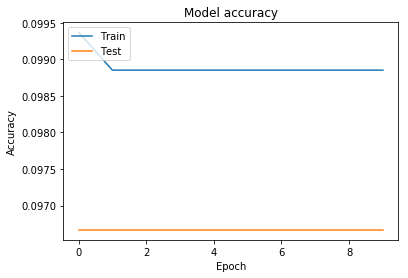

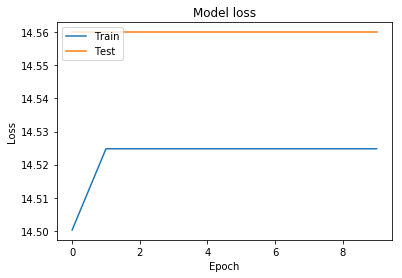

Probamos lr=0.01


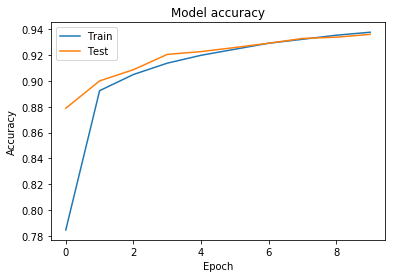

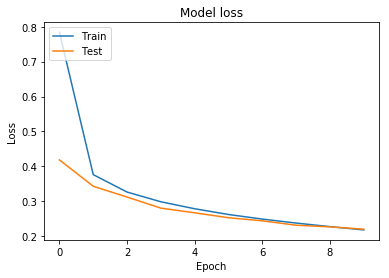

Probamos lr=1e-06


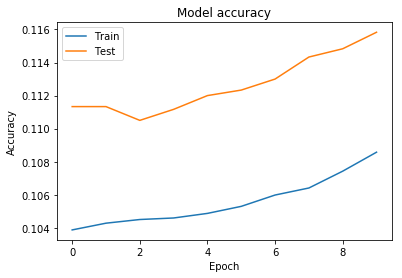

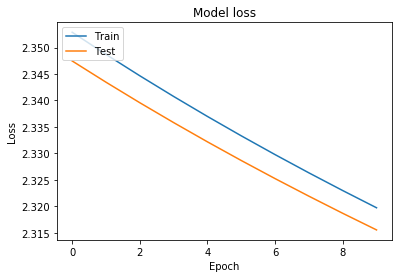

In [14]:
for lr in [1,.01,1e-6]:
    print('Probamos lr={}'.format(lr))
    # Definir el modelo
    model = Sequential(name='model_1')
    model.add(Dense(32, activation='relu', input_dim=784))
    model.add(Dense(10, activation='softmax', name='output_layer'))
    # compilarlo. Usar el learning rate adecuado
    model.compile(optimizer=SGD(lr=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    # entrenarlo
    model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(x_val, y_val))
    # mostrar entrenamiento
    plot_history(model.history)

**regularizacion** En la siguiente sección, vamos a robustecer al modelo, utilizando regularización L2 en su capa oculta. Esto es, dada la función de costo que estamos minimizando:
$$L(W) = \sum_{i=1}^{n} L_i(W) $$
agregar una penalizacion a los pesos
$$L(W) = \sum_{i=1}^{n} L_i(W)+ \lambda \frac{1}{2} |W|^{2}_{2}$$

Se encuentra [implementado en keras](https://keras.io/regularizers/) en el modulo `regularizers`, y hay que pasarlo como parametro al crear la capa oculta que se desea regularizar:

```python
from keras import regularizers
model.add(Dense(64, input_dim=64, activation="sigmoid",
                kernel_regularizer=regularizers.l2(0.01)))
```

El único parámetro que recibe es el $\lambda$, que indica cuanto peso tiene la regularización.

**Se pide**: Entrenar el modelo con el learning rate seleccionado el paso anterior, utilizando $\lambda = 1$ y $\lambda=1e-3$. En ambos casos, graficar la evolución del error.
¿Qué diferencias se observan? ¿A qué se atribuye? ¿Cuál funciona mejor?

Probamos l=1


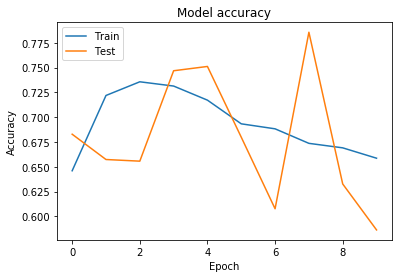

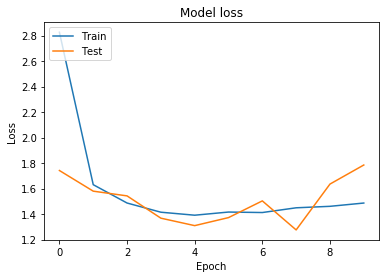

Probamos l=0.001


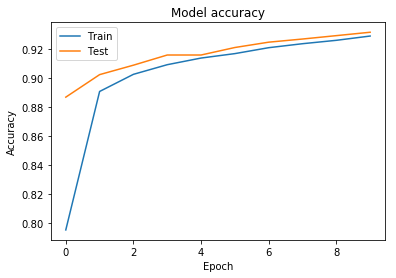

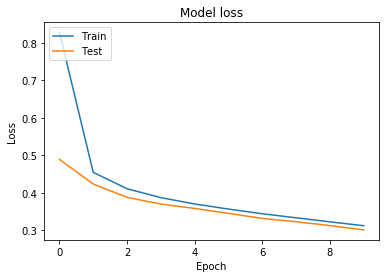

In [17]:
from keras import regularizers

for l in [1,1e-3]:
    print('Probamos l={}'.format(l))
    # Definir el modelo
    model = Sequential(name='model_1')
    model.add(Dense(32, activation='relu', input_dim=784, kernel_regularizer=regularizers.l2(l)))
    model.add(Dense(10, activation='softmax', name='output_layer'))
    # compilarlo. Usar el learning rate adecuado
    model.compile(optimizer=SGD(lr=.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    # entrenarlo
    model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(x_val, y_val))
    # mostrar entrenamiento
    plot_history(model.history)

Implementar un modelo similar al anerior, pero que en vez de tener una unica capa oculta con 32 neuronas, contenga 3 capas ocultas con 5 neuronas cada una.

Compilarlo, y entrenarlo con la misma configuración usada en pasos anteriores. Mostrar cómo cambió su desempeño durante el entrenamiento. Mostrar el resumen del modelo con `model.summary()`

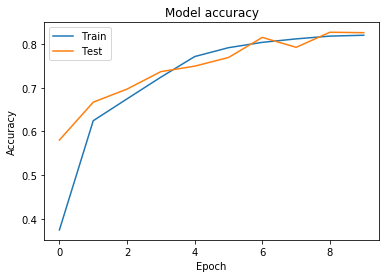

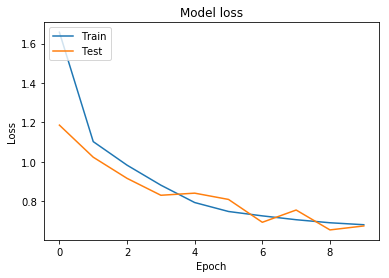

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 30        
_________________________________________________________________
output_layer (Dense)         (None, 10)                60        
Total params: 4,045
Trainable params: 4,045
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Definir el modelo
model = Sequential(name='model_1')
model.add(Dense(5, activation='relu', input_dim=784, kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(5, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(5, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dense(10, activation='softmax', name='output_layer'))
# compilarlo. Usar el learning rate adecuado
model.compile(optimizer=SGD(lr=.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# entrenarlo
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(x_val, y_val))
# mostrar entrenamiento
plot_history(model.history)

model.summary()

**Batch normalization** A continuación, vamos a aplicar batch normalization al modelo anterior para ver si al menos podemos entrenar el modelo.

Batch normalization debe ser aplicado inmediatamente **después** de computar las preactivacion, pero **antes** de aplicar la función de activación. Sin embargo, en los ejemplos vistos, ambas operaciones la ejecuta la misma capa: 

```python
model.add(Dense(64, input_dim=64, activation="sigmoid", 
      kernel_regularizer=regularizers.l2(0.01)))
```

Para aplicar batch normalization, se debe utilizar una funcion de activacion lineal en la capa densa, luego agregar la capa de batch normalization, y por ultimo agregar explicitamente la capa de activacion que querramos usar. El ejemplo anterior, se reescribe como sigue:

```python
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization

model.add(Dense(64, input_dim=64, # no especificar activacion! 
          kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

```

**Se pide:** Entrenar nuevamente el modelo, esta vez agregando batch normalization a cada capa. Mostrar el desarrollo del entrenamiento y el resumen del modelo. ¿Qué se puede decir de este modelo en comparación con el anterior? ¿y con los anteriores a este? (1 capa oculta de 32 neuronas)

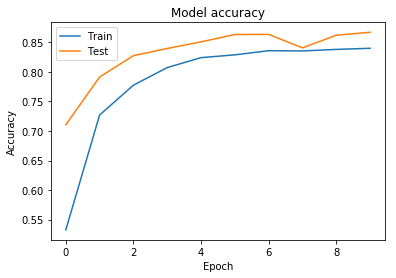

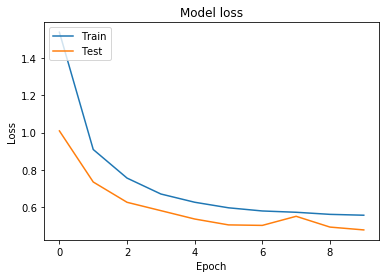

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 5)                 3925      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5)                 20        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 30        
_________________________________________________________________
batch_normalization_2 (Batch (None, 5)                 20        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 30        
__________

In [23]:
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization

# Definir el modelo
model = Sequential(name='model_1')
model.add(Dense(5, input_dim=784, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax', name='output_layer'))
# compilarlo. Usar el learning rate adecuado
model.compile(optimizer=SGD(lr=.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# entrenarlo
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(x_val, y_val))
# mostrar entrenamiento
plot_history(model.history)

model.summary()

**Opcional**: repetir el experimento anterior, cambiando la función de activación utilizada de sigmoid a relu, y utilizar como algoritmo de descenso por gradiente Rmsprop, con sus parámetros por defecto.

Comparar resultados con el escenario anterior.

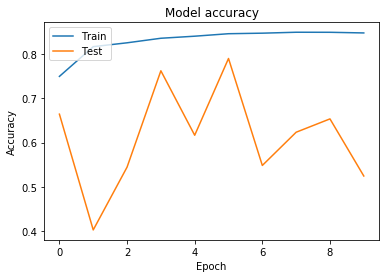

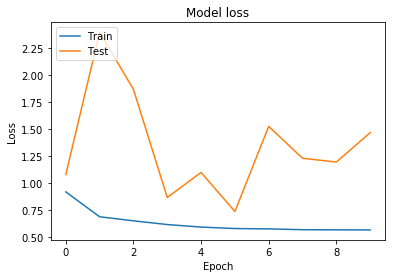

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 5)                 3925      
_________________________________________________________________
batch_normalization_6 (Batch (None, 5)                 20        
_________________________________________________________________
activation_6 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 30        
_________________________________________________________________
batch_normalization_7 (Batch (None, 5)                 20        
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 30        
__________

In [27]:
from keras.optimizers import RMSprop

# Definir el modelo
model = Sequential(name='model_1')
model.add(Dense(5, input_dim=784, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(5, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(5, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(10, activation='softmax', name='output_layer'))
# compilarlo. Usar el learning rate adecuado
model.compile(optimizer=RMSprop(lr=.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# entrenarlo
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(x_val, y_val))
# mostrar entrenamiento
plot_history(model.history)

model.summary()

**Dropout** Dropout es una capa muy sencilla de utilizar. Simplemente se agrega luego de la capa de activación como una capa más, indicanto la proporción de neuronas que se desean eliminar:

```python
from keras.layers import Dropout

model.add(Dropout(.2))  # 20%

```

**early stopping** Keras permite definir diferentes [_callbacks_](https://keras.io/callbacks/). Esto son funciones auxiliares que se ejecutan durante el entrenamiento, al terminar un batch o una epoca. Esto es muy util para monitorear el entrenamiento, y entre otras cosas implementa EarlyStopping.

Se debe definir una lista con los callbacks a ser ejecutados, y luego se pasa esta lista al metodo fit.

```python
from keras.callbacks import EarlyStopping
ea = EarlyStopping(monitor='val_loss',
                   patience=2,
                   restore_best_weights=True)

cb_list = [ea] # lista de callbacks

model.fit(x_train, y_train, 
          validation_data=[x_val, y_val], 
          epochs=10, batch_size=32, callbacks=cb_list);

```

**Se pide**:
Utilizando las herramientas vistas hasta el momento, entrenar el mejor modelo posible, que tenga 2 capas ocultas.

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 12s 213us/step - loss: 0.9411 - acc: 0.7270 - val_loss: 0.7579 - val_acc: 0.7967
Epoch 2/10
54000/54000 [==============================] - 9s 163us/step - loss: 0.8403 - acc: 0.7666 - val_loss: 0.6499 - val_acc: 0.8303
Epoch 3/10
54000/54000 [==============================] - 9s 164us/step - loss: 0.8302 - acc: 0.7697 - val_loss: 0.6177 - val_acc: 0.8492
Epoch 4/10
54000/54000 [==============================] - 9s 174us/step - loss: 0.8105 - acc: 0.7747 - val_loss: 0.6227 - val_acc: 0.8362
Epoch 5/10
54000/54000 [==============================] - 9s 167us/step - loss: 0.7964 - acc: 0.7792 - val_loss: 0.7369 - val_acc: 0.7955
Epoch 6/10
54000/54000 [==============================] - 9s 170us/step - loss: 0.7853 - acc: 0.7819 - val_loss: 0.7065 - val_acc: 0.7950
Epoch 7/10
54000/54000 [==============================] - 9s 166us/step - loss: 0.7924 - acc: 0.7804 - val_loss: 0.5768 - 

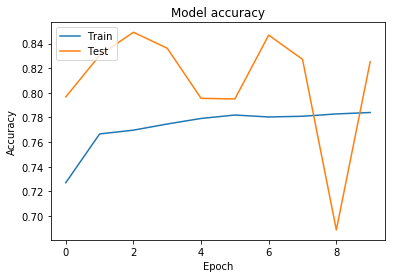

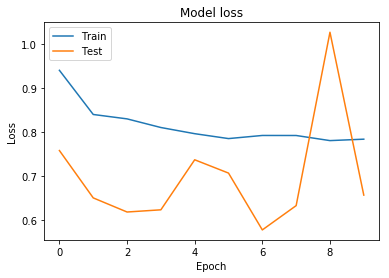

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 5)                 3925      
_________________________________________________________________
batch_normalization_15 (Batc (None, 5)                 20        
_________________________________________________________________
activation_15 (Activation)   (None, 5)                 0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 30        
_________________________________________________________________
batch_normalization_16 (Batc (None, 5)                 20        
_________________________________________________________________
activation_16 (Activation)   (None, 5)                 0         
__________

In [30]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential(name='model_1')
model.add(Dense(5, input_dim=784, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(.05))
model.add(Dense(5, kernel_regularizer=regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax', name='output_layer'))
# compilarlo. Usar el learning rate adecuado
model.compile(optimizer=RMSprop(lr=.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ea = EarlyStopping(monitor='val_loss',
#                    patience=2,
#                    restore_best_weights=True)

# entrenarlo
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, y_val))
# mostrar entrenamiento
plot_history(model.history)

model.summary()

Por ultimo, reportar la performance del mejor modelo encontrado sobre el conjunto de test.

In [33]:
from sklearn.metrics import classification_report

# Hacer las predicciones y mostrar el reporte sobre conjunto de test
predictions = model.predict(x_test)
y_test_pred = np.argmax(predictions, axis=1)
print(classification_report(y_test, y_test_pred))

print(sum(y_test_pred-y_test)/len(y_test))

             precision    recall  f1-score   support

          0       0.93      0.90      0.91       980
          1       0.96      0.88      0.92      1135
          2       0.86      0.82      0.84      1032
          3       0.93      0.64      0.76      1010
          4       0.71      0.94      0.81       982
          5       0.70      0.83      0.76       892
          6       0.86      0.87      0.87       958
          7       0.82      0.88      0.85      1028
          8       0.82      0.74      0.77       974
          9       0.78      0.81      0.79      1009

avg / total       0.84      0.83      0.83     10000

0.0949
